# Multi omics analysis by MOFA
MOFA is a factor analysis model that provides a general framework for the integration of multi-omic data sets in an unsupervised fashion.

This tutorial focuses on how to perform mofa in multi-omics like scRNA-seq and scATAC-seq

Paper: [MOFA+: a statistical framework for comprehensive integration of multi-modal single-cell data](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1)

Code: https://github.com/bioFAM/mofapy2

Colab_Reproducibility：https://colab.research.google.com/drive/1UPGQA3BenrC-eLIGVtdKVftSnOKIwNrP?usp=sharing

## Part.1 MOFA Model
In this part, we construct a model of mofa by scRNA-seq and scATAC-seq

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import omicverse as ov
ov.plot_set(font_path='Arial')
!date

rna=ov.utils.read('data/atac-pp.h5ad')
atac=ov.utils.read('data/atac-pp.h5ad')

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.6rc1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.

2025年 08月 05日 星期二 17:30:45 CST


In [3]:
rna,atac

(AnnData object with n_obs × n_vars = 9190 × 241757
     obs: 'domain', 'cell_type'
     var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
     uns: 'cell_type_colors', 'neighbors', 'umap'
     obsm: 'X_lsi', 'X_umap'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 9190 × 241757
     obs: 'domain', 'cell_type'
     var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
     uns: 'cell_type_colors', 'neighbors', 'umap'
     obsm: 'X_lsi', 'X_umap'
     obsp: 'connectivities', 'distances')

In [4]:
import random

def select_random_elements(lst, num_elements):
    if num_elements >= len(lst):
        return lst  # If the number of elements to be selected is
        # greater than or equal to the length of the original list, return the entire list directly
    else:
        return random.sample(lst, num_elements)

# Origin List
original_list = rna.obs.index.tolist()

# Select 3000 Random element from the original list
new_list_rna = select_random_elements(original_list, 3000)

# Modify the index of the adaptive atac file
original_list = new_list_rna
new_list_atac = [element.replace("_RNA", "_ATAC") for element in original_list]
rna = rna[new_list_rna]
atac = atac[new_list_atac]

In [5]:
# use highly variable genes/features
rna=rna[:,rna.var['highly_variable']==True]
atac=atac[:,atac.var['highly_variable']==True]
rna, atac

(View of AnnData object with n_obs × n_vars = 3000 × 25488
     obs: 'domain', 'cell_type'
     var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
     uns: 'cell_type_colors', 'neighbors', 'umap'
     obsm: 'X_lsi', 'X_umap'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 3000 × 25488
     obs: 'domain', 'cell_type'
     var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable'
     uns: 'cell_type_colors', 'neighbors', 'umap'
     obsm: 'X_lsi', 'X_umap'
     obsp: 'connectivities', 'distances')

We only need to add anndata to `ov.single.mofa` to construct the base model

In [6]:
test_mofa=ov.single.pyMOFA(omics=[rna,atac],
                             omics_name=['RNA','ATAC'])

In [7]:
test_mofa.mofa_preprocess()
test_mofa.mofa_run(outfile='models/brac_rna_atac.hdf5')


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Successfully loaded view='RNA' group='group0' with N=3000 samples and D=25488 features...
Successfully loaded view='ATAC' group='group0' with N=3000 samples and D=25488 features...




Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Deter

## Part.2 MOFA Analysis
After get the model by mofa, we need to analysis the factor about different omics, we provide some method to do this

### load data

In [33]:
import omicverse as ov
ov.plot_set(font_path='Arial')

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf
Registered as: Arial
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ [GPU 1] NVIDIA GeForce RTX 2080 Ti
    • Total memory: 10.7 GB
    • Compute capability: 7.5
✅ plot_set complete.



In [34]:
import re
new_list_rna = [re.sub(r'_ATAC$', '_RNA', s) for s in original_list]

rna=ov.utils.read('data/rna-pp.h5ad')
rna = rna[new_list_rna]
rna

View of AnnData object with n_obs × n_vars = 3000 × 28930
    obs: 'domain', 'cell_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### add value of factor to anndata

In [35]:
rna=ov.single.factor_exact(rna,hdf5_path='models/brac_rna_atac.hdf5')
rna

AnnData object with n_obs × n_vars = 3000 × 28930
    obs: 'domain', 'cell_type', 'factor1', 'factor2'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### analysis of the correlation between factor and cell type

In [37]:
ov.single.factor_correlation(adata=rna,cluster='cell_type',factor_list=[1,2,])

,factor1,factor2
Mic,0.153242,0.073005
InS,1.501327,0.063867
E5Tshz2,2.931139,0.000869
OPC,3.816029,0.016524
InN,0.991213,0.047858
E3Rorb,8.588916,0.225156
E3Rmst,0.547523,0.161757
OliM,3.994645,0.052338
E6Tle4,2.557039,0.274712
E5Parm1,53.156619,0.720247


### Get the gene/feature weights of different factor

In [39]:
ov.single.get_weights(hdf5_path='models/brac_rna_atac.hdf5',view='RNA',factor=1)

,feature,weights,abs_weights,sig
0,b'RNA_chr1:3210899-3211332',0.000047,0.000047,+
1,b'RNA_chr1:3216313-3216806',0.000000,0.000000,+
2,b'RNA_chr1:3217279-3217678',0.000014,0.000014,+
3,b'RNA_chr1:3228082-3228372',0.000009,0.000009,+
4,b'RNA_chr1:3265226-3265683',0.000020,0.000020,+
...,...,...,...,...
25483,b'RNA_chrX:168463550-168464104',0.000177,0.000177,+
25484,b'RNA_chrX:168534296-168534829',0.004916,0.004916,+
25485,b'RNA_chrX:168549302-168549575',0.000006,0.000006,+
25486,b'RNA_chrX:168563134-168563359',-0.000005,0.000005,-


## Part.3 MOFA Visualize

To visualize the result of mofa, we provide a series of function to do this.

In [40]:
pymofa_obj=ov.single.pyMOFAART(model_path='models/brac_rna_atac.hdf5')

We get the factor of each cell at first

In [41]:
pymofa_obj.get_factors(rna)
rna

......Add factors to adata and store to adata.obsm["X_mofa"]


AnnData object with n_obs × n_vars = 3000 × 28930
    obs: 'domain', 'cell_type', 'factor1', 'factor2'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag'
    uns: 'cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_mofa'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

We can also plot the varience in each View

(<Figure size 160x240 with 2 Axes>,
 <Axes: title={'center': 'Varience'}, xlabel='View', ylabel='Factor'>)

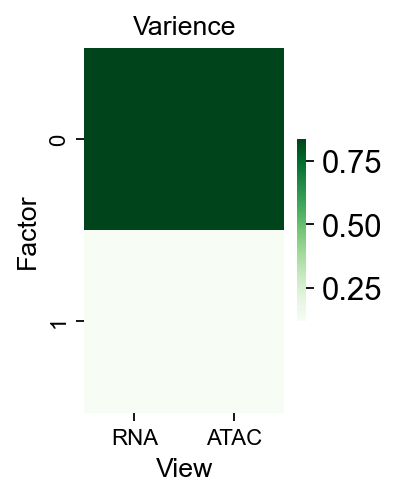

In [42]:
pymofa_obj.plot_r2()

In [43]:
pymofa_obj.get_r2()

,RNA,ATAC
0,0.837996,0.837996
1,0.117224,0.117224


### Visualize the correlation between factor and celltype

(<Figure size 480x240 with 2 Axes>,
 <Axes: title={'center': 'Correlation'}, xlabel='Factor', ylabel='cell_type'>)

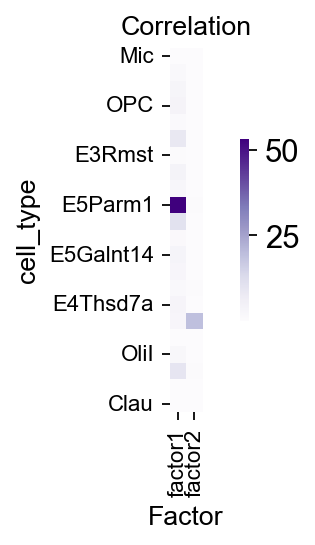

In [44]:
pymofa_obj.plot_cor(rna,'cell_type')

We found that factor6 is correlated to Epithelial

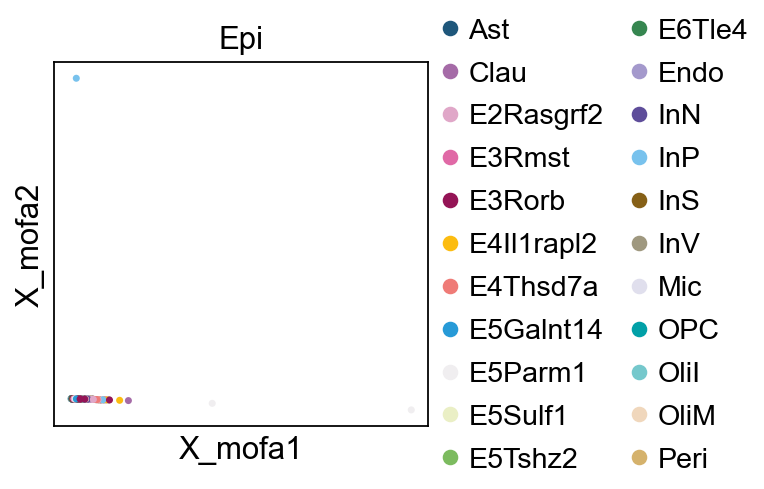

(<Figure size 240x240 with 1 Axes>,
 <Axes: title={'center': 'Epi'}, xlabel='X_mofa1', ylabel='X_mofa2'>)

In [46]:
pymofa_obj.plot_factor(rna,'cell_type','Epi',figsize=(3,3),
                    factor1=1,factor2=2,)

computing neighbors
    using 'X_pca' with n_pcs = 100


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


[<Axes: title={'center': 'factor2'}, xlabel='X_umap1', ylabel='X_umap2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='X_umap1', ylabel='X_umap2'>]

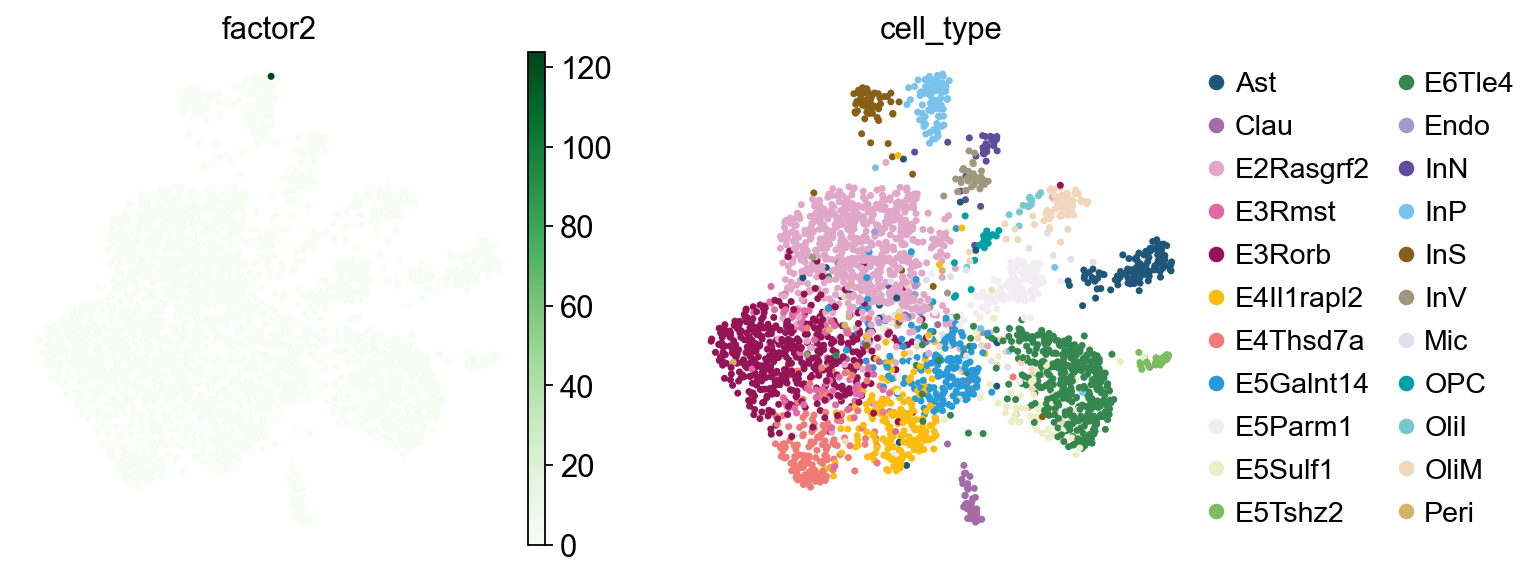

In [47]:
import scanpy as sc
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.pl.embedding(
    rna,
    basis="X_umap",
    color=["factor2","cell_type"],
    frameon=False,
    ncols=2,
    #palette=ov.utils.pyomic_palette(),
    show=False,
    cmap='Greens',
    vmin=0,
)
#plt.savefig("figures/umap_factor6.png",dpi=300,bbox_inches = 'tight')


(<Figure size 240x240 with 1 Axes>,
 <Axes: xlabel='factor_1', ylabel='factor_2'>)

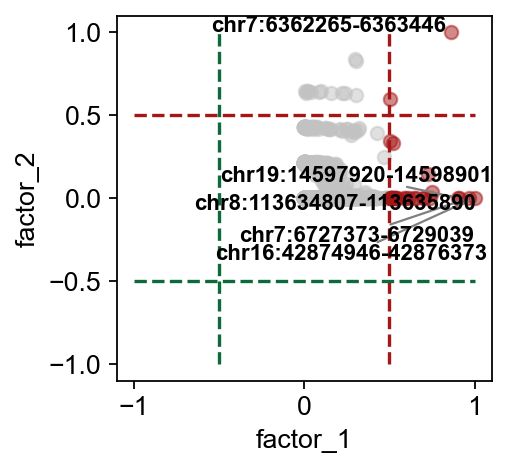

In [48]:
pymofa_obj.plot_weight_gene_d1(view='RNA',factor1=1,factor2=2,)

(<Figure size 240x320 with 1 Axes>,
 <Axes: title={'center': 'factor_2'}, xlabel='Feature rank', ylabel='Weight'>)

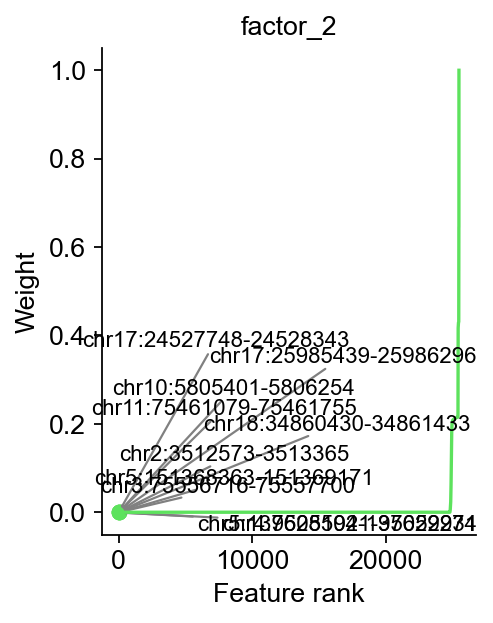

In [50]:
pymofa_obj.plot_weights_gene_factor(view='RNA',factor=2,color='#5de25d',
                        ascending=True)

computing PCA
    with n_comps=3
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Factor']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


{'mainplot_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

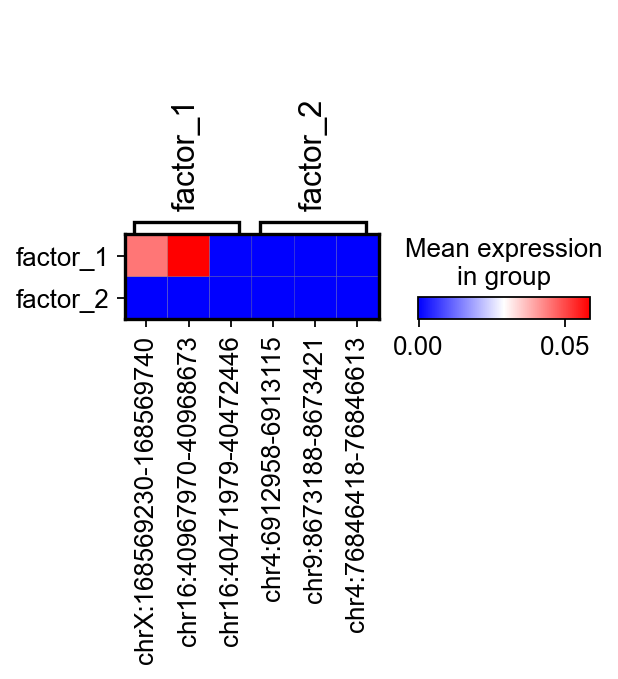

In [53]:
pymofa_obj.plot_top_feature_heatmap(view='RNA', n_pcs=3)